<a href="https://colab.research.google.com/github/shehanp-dev/Ramanujan-s-Door-Number-Problem-From-Street-Numbers-to-Continued-Fractions/blob/main/PINN_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1:Import the necessary libraries for building the Physics-Informed Neural Network. PyTorch for deep learning, NumPy for numerical operations, and Matplotlib for visualization.

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Part2:
Generate synthetic experimental data for N₂O₅ decomposition. We simulate concentration measurements over time using the first-order kinetics equation: $$[A](t) = [A]_0 e^{-kt}$$
We add 8% Gaussian noise to simulate real experimental errors from measurement instruments.

In [12]:
# --------------------------
# Generate Synthetic Data for N2O5 Decomposition
# --------------------------

# Chemical kinetics parameters
k_true = 3.38e-5      # rate constant (s^-1) at 25°C
A0_true = 1.0         # initial concentration (M)

# Normalize time to [0, 1] range
t_min, t_max = 0.0, 60000.0
t_scale = t_max  # Used for normalization

# True solution with normalized time
def true_solution(t_norm):
    t = t_norm * t_scale  # Convert back to seconds
    return A0_true * np.exp(-k_true * t)

# Generate time points (normalized to [0, 1])
N_data = 15
t_data_norm = np.linspace(0.0, 1.0, N_data)

# Generate synthetic "experimental" concentrations with noise
np.random.seed(42)
noise_level = 0.08 * A0_true  # 8% noise
A_data_exact = true_solution(t_data_norm)
A_data_noisy = A_data_exact + noise_level * np.random.randn(N_data)
A_data_noisy = np.maximum(A_data_noisy, 0.01)  # Avoid zeros

# Convert to PyTorch tensors
t_data_tensor = torch.tensor(t_data_norm, dtype=torch.float32).view(-1, 1)
A_data_tensor = torch.tensor(A_data_noisy, dtype=torch.float32).view(-1, 1)

print(f"True rate constant k = {k_true:.6e} s^-1")
print(f"Half-life t_1/2 = {np.log(2)/k_true/3600:.2f} hours")
print(f"Time scale factor = {t_scale} seconds")

True rate constant k = 3.380000e-05 s^-1
Half-life t_1/2 = 5.70 hours
Time scale factor = 60000.0 seconds


Part 3: Build a Physics-Informed Neural Network for chemical kinetics. The network takes time $(t)$ as input and predicts $N_2O_5$ concentration $[A]$ as output. We use 2 hidden layers with 20 neurons each and $tanh$ activation function for smooth derivatives. Importantly, we make the rate constant $k$ a learnable parameter that the network will discover from the data.

In [13]:
# --------------------------------------------------------
# Define Neural Network with Learnable Rate Constant
# --------------------------------------------------------
class ChemistryPINN(nn.Module):
    def __init__(self, n_hidden=32):
        super(ChemistryPINN, self).__init__()
        # Deeper network with more neurons
        self.net = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),  # Extra layer
            nn.Tanh(),
            nn.Linear(n_hidden, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )

        # Initialize k close to true value (scaled for normalized time)
        k_init = k_true * t_scale  # Scale k for normalized time
        self.k = nn.Parameter(torch.tensor([k_init], dtype=torch.float32))

    def forward(self, t):
        """
        Forward pass: input normalized time -> output concentration
        Output is scaled to [0, A0_true]
        """
        return self.net(t) * A0_true

# Instantiate the model
model = ChemistryPINN(n_hidden=32)
print(f"Initial rate constant (scaled): k = {model.k.item():.6f}")
print(f"Expected k (scaled) = {k_true * t_scale:.6f}")

Initial rate constant (scaled): k = 2.028000
Expected k (scaled) = 2.028000


Part 4:This function computes derivatives automatically using PyTorch's autograd. We need this to calculate $d[A]/dt$ from the neural network's concentration predictions, which is essential for enforcing the rate equation in our physics loss.

In [14]:
# --------------------------------
# Autograd for Automatic Differentiation
# --------------------------------
def derivative(y, x):
    """
    Computes dy/dx using PyTorch's autograd.
    y and x must be tensors with requires_grad=True for x.
    """
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

Part 5:Define three loss components for training the PINN:

Data Loss: Ensures predictions match experimental concentration measurements

Physics Loss (ODE Loss): Enforces the first-order rate equation: $$ \\\frac{d[A]}{dt} = -k[A]$$

Initial Condition Loss: Ensures concentration at $t=0$ equals the initial concentration $[A]_0$

In [15]:
# ----------------------------------------
# Define the Loss Components (PINN) - Fixed for Normalized Time
# ----------------------------------------

def physics_loss(model, t_norm):
    """
    Enforce the rate equation: d[A]/dt = -k*[A]
    With normalized time: d[A]/dt_norm = -k_scaled * [A] / t_scale
    """
    t_norm.requires_grad_(True)
    A_pred = model(t_norm)

    # Compute derivative w.r.t. normalized time
    dA_dt_norm = derivative(A_pred, t_norm)

    # Physics: dA/dt = -k*A
    # With t_norm = t/t_scale: dA/dt_norm = (dA/dt) * t_scale = -k*A*t_scale
    # Rearranged: dA/dt_norm + k*t_scale*A = 0
    residual = dA_dt_norm + model.k * A_pred

    loss_ode = torch.mean(residual**2)
    return loss_ode

def initial_condition_loss(model, A0):
    """
    Enforce [A](0) = A0.
    """
    t0 = torch.zeros(1, 1, dtype=torch.float32, requires_grad=False)
    A0_pred = model(t0)
    return (A0_pred - A0).pow(2).mean()

def data_loss(model, t_data, A_data):
    """
    MSE between predicted [A](t_i) and noisy measurements.
    """
    A_pred = model(t_data)
    return torch.mean((A_pred - A_data)**2)

Part 6:Set up the training configuration. We use the Adam optimizer with a learning rate of $0.001$. The $λ$ weights control the relative importance of each loss term. Higher weights on physics and initial condition losses help the network respect the underlying chemistry while still fitting the noisy experimental data.

In [16]:
# ---------------------------------------
# Training Setup
# ---------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

lambda_data = 10.0
lambda_ode  = 10.0
lambda_ic   = 50.0

num_epochs = 15000
print_every = 1000

Part 7:Train the Physics-Informed Neural Network. In each epoch, we compute all three loss terms, combine them with their weights, and update the network parameters (including the learnable rate constant $k$) via backpropagation. Monitor the progress to see how well the model learns both the concentration profile and the rate constant.

In [17]:
# ---------------------------------------
# Training Loop
# ---------------------------------------
model.train()
loss_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute losses
    l_data = data_loss(model, t_data_tensor, A_data_tensor)
    l_ode  = physics_loss(model, t_data_tensor)
    l_ic   = initial_condition_loss(model, A0_true)

    # Combined loss
    loss = lambda_data * l_data + lambda_ode * l_ode + lambda_ic * l_ic

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Store loss
    loss_history.append(loss.item())

    # Print progress
    if (epoch+1) % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Total Loss = {loss.item():.6f}")
        print(f"  Data Loss = {l_data.item():.6f}")
        print(f"  ODE Loss = {l_ode.item():.6f}")
        print(f"  IC Loss = {l_ic.item():.6f}")
        print(f"  Learned k = {model.k.item():.6e} s^-1")
        print()

Epoch 1000/15000
  Total Loss = 0.077915
  Data Loss = 0.006321
  ODE Loss = 0.000224
  IC Loss = 0.000249
  Learned k = 1.816181e+00 s^-1

Epoch 2000/15000
  Total Loss = 0.066327
  Data Loss = 0.005375
  ODE Loss = 0.000487
  IC Loss = 0.000154
  Learned k = 1.964276e+00 s^-1

Epoch 3000/15000
  Total Loss = 0.068604
  Data Loss = 0.004952
  ODE Loss = 0.000866
  IC Loss = 0.000208
  Learned k = 2.018181e+00 s^-1

Epoch 4000/15000
  Total Loss = 0.057430
  Data Loss = 0.004874
  ODE Loss = 0.000299
  IC Loss = 0.000114
  Learned k = 2.064589e+00 s^-1

Epoch 5000/15000
  Total Loss = 0.125628
  Data Loss = 0.005179
  ODE Loss = 0.006029
  IC Loss = 0.000271
  Learned k = 2.079418e+00 s^-1

Epoch 6000/15000
  Total Loss = 0.057957
  Data Loss = 0.005055
  ODE Loss = 0.000048
  IC Loss = 0.000139
  Learned k = 2.057707e+00 s^-1

Epoch 7000/15000
  Total Loss = 0.055938
  Data Loss = 0.004606
  ODE Loss = 0.000390
  IC Loss = 0.000120
  Learned k = 2.170383e+00 s^-1

Epoch 8000/15000
  T

Part 8:Evaluate the trained PINN and compare the learned rate constant with the true value. Calculate the percentage error and the predicted half-life. The PINN should successfully discover the rate constant from noisy data while respecting the underlying physics.

In [18]:
# ---------------------------------------
# 7. Evaluate the Trained Model
# ---------------------------------------
model.eval()

# CRITICAL: Convert learned k back from scaled to original units
k_learned_scaled = model.k.item()  # This is k_scaled
k_learned = k_learned_scaled / t_scale  # Convert back to s^-1

k_error = abs(k_learned - k_true) / k_true * 100

# Calculate half-lives
t_half_true = np.log(2) / k_true
t_half_learned = np.log(2) / k_learned

# Get initial concentration prediction
with torch.no_grad():
    t0 = torch.zeros(1, 1, dtype=torch.float32)
    A0_pred = model(t0).item()
A0_error = abs(A0_pred - A0_true) / A0_true * 100

print("="*60)
print("RESULTS SUMMARY")
print("="*60)
print(f"True rate constant:    k = {k_true:.6e} s^-1")
print(f"Learned rate constant: k = {k_learned:.6e} s^-1")
print(f"Error:                 {k_error:.2f}%")
print()
print(f"True k_scaled:         k_scaled = {k_true * t_scale:.6f}")
print(f"Learned k_scaled:      k_scaled = {k_learned_scaled:.6f}")
print()
print(f"True half-life:        t_1/2 = {t_half_true:.2f} s = {t_half_true/3600:.2f} hours")
print(f"Learned half-life:     t_1/2 = {t_half_learned:.2f} s = {t_half_learned/3600:.2f} hours")
print()
print(f"True [A]_0:            {A0_true:.4f} M")
print(f"Learned [A]_0:         {A0_pred:.4f} M")
print(f"Error in [A]_0:        {A0_error:.2f}%")
print()
print(f"Time scale factor:     {t_scale:.0f} seconds = {t_scale/3600:.2f} hours")
print("="*60)

RESULTS SUMMARY
True rate constant:    k = 3.380000e-05 s^-1
Learned rate constant: k = 3.550057e-05 s^-1
Error:                 5.03%

True k_scaled:         k_scaled = 2.028000
Learned k_scaled:      k_scaled = 2.130034

True half-life:        t_1/2 = 20507.31 s = 5.70 hours
Learned half-life:     t_1/2 = 19524.96 s = 5.42 hours

True [A]_0:            1.0000 M
Learned [A]_0:         0.9933 M
Error in [A]_0:        0.67%

Time scale factor:     60000 seconds = 16.67 hours


Part 9:Visualization of $N_2O_5$ decomposition kinetics. Left panel shows the concentration decay with PINN prediction.Right panel shows the logarithmic plot confirming first-order kinetics.

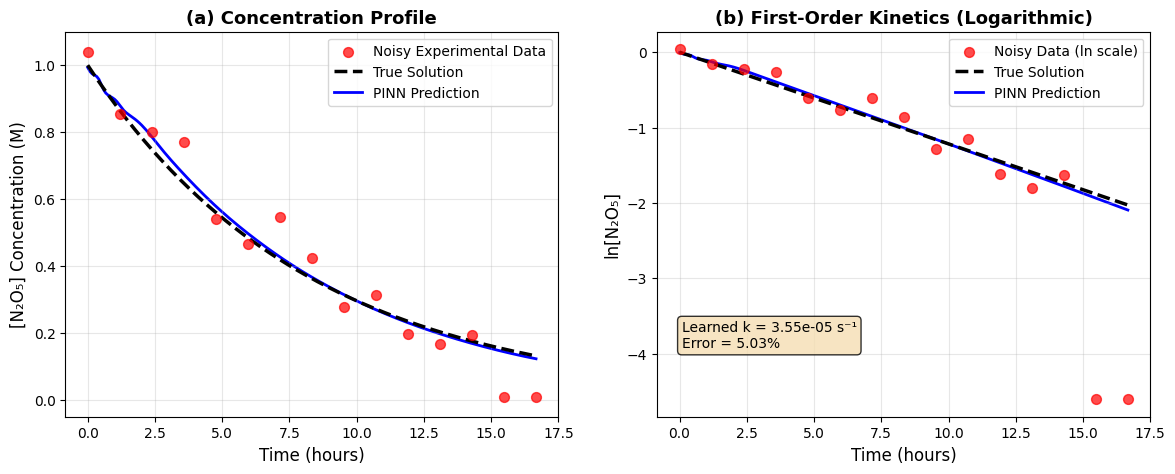

Combined plot saved as 'N2O5_PINN_combined_plots.png'


In [19]:
import matplotlib.pyplot as plt

# Plots: Concentration and Logarithmic
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Generate fine time grid for plotting
t_plot_norm = np.linspace(0.0, 1.0, 200).reshape(-1, 1).astype(np.float32)
t_plot_tensor = torch.tensor(t_plot_norm, requires_grad=False)

# Get PINN predictions
model.eval()
with torch.no_grad():
    A_pred_plot = model(t_plot_tensor).numpy()

# True solution for comparison
A_true_plot = true_solution(t_plot_norm)

# Convert normalized time back to hours for plotting
t_plot_hours = t_plot_norm.flatten() * t_scale / 3600
t_data_hours = t_data_norm * t_scale / 3600

# ============================================================
# LEFT PANEL: Concentration vs Time
# ============================================================
ax1 = axes[0]
ax1.scatter(t_data_hours, A_data_noisy, color='red', s=50,
            label='Noisy Experimental Data', zorder=3, alpha=0.7)
ax1.plot(t_plot_hours, A_true_plot, 'k--', linewidth=2.5,
         label='True Solution', zorder=2)
ax1.plot(t_plot_hours, A_pred_plot, 'b-', linewidth=2,
         label='PINN Prediction', zorder=1)
ax1.set_xlabel('Time (hours)', fontsize=12)
ax1.set_ylabel('[N₂O₅] Concentration (M)', fontsize=12)
ax1.set_title('(a) Concentration Profile', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.05, 1.1)

# ============================================================
# RIGHT PANEL: Logarithmic Plot (ln[A] vs Time)
# ============================================================
ax2 = axes[1]

# Calculate ln values (avoid log of zero or negative)
A_data_noisy_safe = np.maximum(A_data_noisy, 1e-6)
ln_A_data = np.log(A_data_noisy_safe)
ln_A_true = np.log(np.maximum(A_true_plot, 1e-6))
ln_A_pred = np.log(np.maximum(A_pred_plot.flatten(), 1e-6))

ax2.scatter(t_data_hours, ln_A_data, color='red', s=50,
            label='Noisy Data (ln scale)', zorder=3, alpha=0.7)
ax2.plot(t_plot_hours, ln_A_true, 'k--', linewidth=2.5,
         label='True Solution', zorder=2)
ax2.plot(t_plot_hours, ln_A_pred, 'b-', linewidth=2,
         label='PINN Prediction', zorder=1)
ax2.set_xlabel('Time (hours)', fontsize=12)
ax2.set_ylabel('ln[N₂O₅]', fontsize=12)
ax2.set_title('(b) First-Order Kinetics (Logarithmic)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10, loc='upper right')
ax2.grid(True, alpha=0.3)

# Add text box with learned parameters
textstr = f'Learned k = {k_learned:.2e} s⁻¹\nError = {k_error:.2f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax2.text(0.05, 0.25, textstr, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.savefig('N2O5_PINN_combined_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Combined plot saved as 'N2O5_PINN_combined_plots.png'")

Part 10:Visualize how the total loss decreases during training. A smooth decrease indicates successful learning. The PINN simultaneously learns to fit the data, obey the rate equation, and satisfy the initial condition.

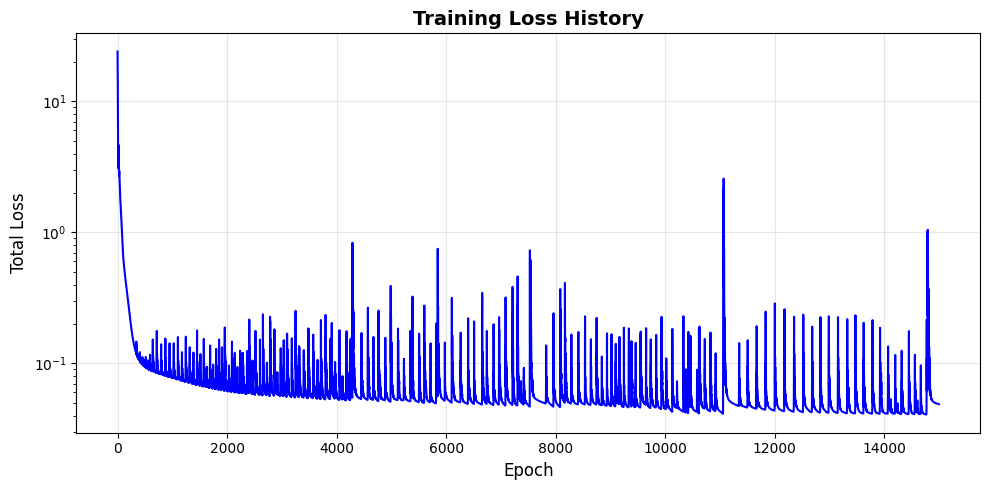

In [20]:
# Plot training loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history, 'b-', linewidth=1.5)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Total Loss', fontsize=12)
plt.title('Training Loss History', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()